4.5.3
0.7.1
[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


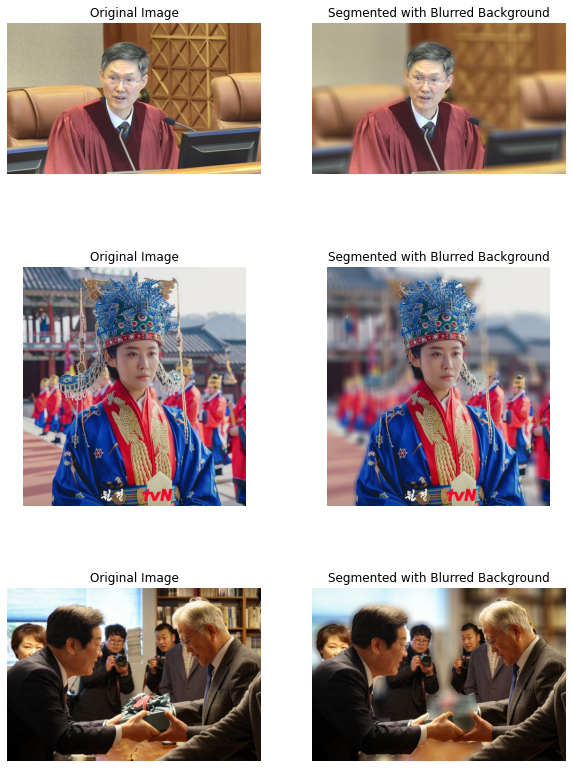

In [1]:
import os
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

from importlib.metadata import version

# OpenCV 및 PixelLib 버전 확인
print(cv2.__version__)
print(version('pixellib'))

# Pascal VOC 데이터셋의 라벨 리스트
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 컬러맵 생성
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])  # 생성된 20개의 컬러맵 출력

# 모델 로드
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation_1/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)  # PASCAL VOC 사전 학습 모델 로드

# ✅ 함수: 세그멘테이션 및 배경 블러 적용
def segment_and_blur_background(img_path, seg_color=(128, 128, 192)):
    """
    이미지 경로를 받아, 특정 객체의 세그멘테이션을 수행하고 배경을 블러 처리하여 반환
    :param img_path: 처리할 이미지 경로
    :param seg_color: 세그멘테이션 마스크 색상 (기본: 사람)
    :return: 원본 이미지, 세그멘테이션 후 배경 블러링 이미지
    """
    img_orig = cv2.imread(img_path)  # 이미지 로드

    # 모델을 사용하여 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # 세그멘테이션 맵 생성
    seg_map = np.all(output == seg_color, axis=-1)

    # 원본 이미지 복사
    img_show = img_orig.copy()

    # 마스크 생성 및 적용
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    # 배경 블러 처리
    img_orig_blur = cv2.blur(img_orig, (23, 23))  # 블러 처리
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 마스크를 컬러로 변환
    img_bg_mask = cv2.bitwise_not(img_mask_color)  # 반전 마스크 생성
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 블러 적용된 배경 생성

    # 배경과 객체를 합성
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

    return img_orig, img_concat

# ✅ 여러 이미지 처리
image_paths = [
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image1.jpg',
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image2.jpg',
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image3.jpg'
]

# ✅ 결과 시각화
fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, len(image_paths) * 5))

for i, img_path in enumerate(image_paths):
    original, segmented = segment_and_blur_background(img_path)

    axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Segmented with Blurred Background")
    axes[i, 1].axis("off")